In [5]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from lightning.pytorch import seed_everything

seed_everything(42)
scvi.settings.seed = 42

Seed set to 42
Seed set to 42


In [6]:
TRAIN_ANNDATA_PATH = '../Proteomics/train_adata.h5ad'

adata = ad.read_h5ad(TRAIN_ANNDATA_PATH)
adata

AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

# PART 1: scVI

## 1) Precompute the representations

### 1.1) PCA on marker expressions

In [7]:
from sklearn.decomposition import PCA

# Extract raw expression data
exprs = adata.layers['exprs']

# Normalize and transform
cell_sums = exprs.sum(axis=1, keepdims=True)
normalized_exprs = (exprs / cell_sums) * 1e6
log_normalized_exprs = np.log1p(normalized_exprs)

# Store normalized data
adata.layers['exprs_normalized'] = log_normalized_exprs

# Perform a PCA that explains 95% of the variance
pca = PCA(n_components=0.95)
expr_pca = pca.fit_transform(log_normalized_exprs)

Explained 0.9514 of variance in 40 markers with 25 components


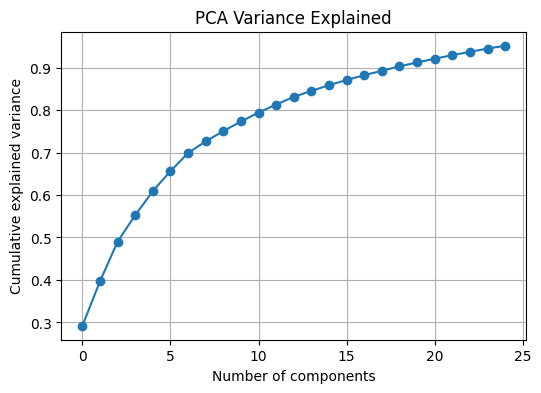

In [8]:
explained_variance = pca.explained_variance_ratio_

total_variance_explained = explained_variance.sum()
num_components = pca.n_components_
num_markers = len(adata.var['marker'])

print(f"Explained {total_variance_explained:.4f} of variance in {num_markers} markers with {num_components} components")

plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

In [9]:
# Store the result
adata.obsm["X_PCA"] = expr_pca

### 1.2) scVI's latent representations

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="exprs_normalized"
)

model = scvi.model.SCVI(adata,
                       gene_likelihood = "normal", # since we're dealing with expressions and not counts (!)
                        n_latent = 25 # set the same dimensionality as in PCA, just to see what happens 
)

/home/olekjanowiak/miniconda3/envs/bs3/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[exprs_normalized] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [11]:
model.train(early_stopping=True, enable_progress_bar=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/32 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=32` reached.


In [12]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

In [13]:
# Optional: save the computed representations
adata.write('representations.h5ad')

In [14]:
! ls

assignment.pdf	README.md  representations.h5ad  scvi.ipynb


## 2) CellCharter on both representations

### Calculate the neighbors of each cell

In [15]:
# create the 'spatial' column expected by squidpy
adata.obsm['spatial'] = adata.obs[['Pos_X', 'Pos_Y']].values

# compute the graph and remove artifacts of Delaunay triangulation
sq.gr.spatial_neighbors(
    adata,
    library_key='sample_id',
    coord_type='generic',
    delaunay=True,             
    spatial_key='spatial',
    key_added='spatial',
    percentile=99
)


In [16]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_PCA', out_key='PCA_aggregated', sample_key='sample_id')

cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='scVI_aggregated', sample_key='sample_id')

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

### Define the model:

In [17]:
# define model parameters
model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator':'gpu'
            },
         }

# define the AutoK
autok = cc.tl.ClusterAutoK(
    n_clusters=(10,30), 
    max_runs=10,
    convergence_tol=0.001,
    model_params = model_params,
)

### 2.1) PCA-based clustering

In [18]:
# cast to float32
adata.obsm["PCA_aggregated"] = adata.obsm["PCA_aggregated"].astype(np.float32)

In [19]:
# cluster the PCA data using AutoK
import time
start = time.time()
autok.fit(adata[::20], use_rep='PCA_aggregated') #downsampling by a factor of 20 to speed up the computation

print("Finished clustering in: ", time.time()-start, "s")

Iteration 1/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 2/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 3/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 4/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 5/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 6/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 7/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 8/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 9/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 10/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Finished clustering in:  328.5769772529602 s


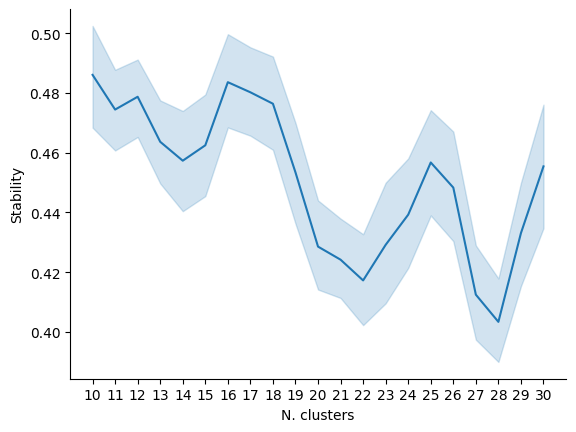

The optimal number of clusters was selected to be 10


In [20]:
# RESULTS
cc.pl.autok_stability(autok)
plt.show()

pca_best_k = autok.best_k
print(f"The optimal number of clusters was selected to be {pca_best_k}")

In [21]:
# assign the computed clusters
adata.obs['PCA_clusters'] = autok.predict(adata, use_rep='PCA_aggregated')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### 2.2) scVI-based clustering

In [22]:
# define the AutoK again
# without this step, the pipeline breaks ಠ_ಠ
autok = cc.tl.ClusterAutoK(
    n_clusters=(10,30), 
    max_runs=10,
    convergence_tol=0.001,
    model_params = model_params,
)

In [23]:
# cast to float32
adata.obsm["scVI_aggregated"] = adata.obsm["scVI_aggregated"].astype(np.float32)

In [24]:
# cluster the PCA data using AutoK
import time
start = time.time()
autok.fit(adata[::20], use_rep='scVI_aggregated') #downsampling by a factor of 20 to speed up the computation

print("Finished clustering in: ", time.time()-start, "s")

Iteration 1/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 2/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 3/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 4/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 5/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 6/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 7/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 8/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 9/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Iteration 10/10


  0%|          | 0/23 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVIC

Finished clustering in:  339.9287030696869 s


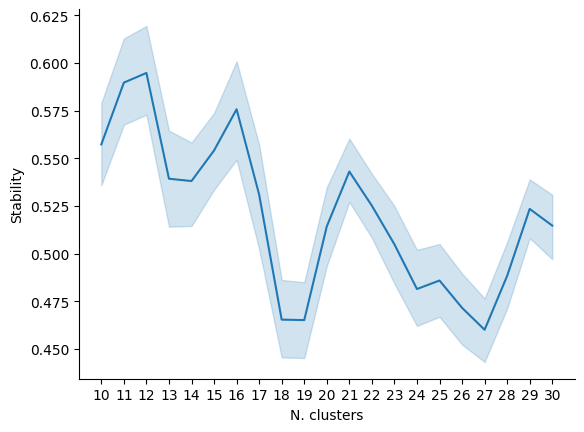

The optimal number of clusters was selected to be 12


In [25]:
# RESULTS
cc.pl.autok_stability(autok)
plt.show()

scvi_best_k = autok.best_k
print(f"The optimal number of clusters was selected to be {scvi_best_k}")

In [26]:
# assign the computed clusters
adata.obs['scVI_clusters'] = autok.predict(adata, use_rep='scVI_aggregated')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [27]:
adata

AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier', '_scvi_batch', '_scvi_labels', 'PCA_clusters', 'scVI_clusters'
    var: 'channel', 'use_channel', 'marker'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'spatial_neighbors'
    obsm: 'X_PCA', 'X_scVI', 'spatial', 'PCA_aggregated', 'scVI_aggregated'
    layers: 'exprs', 'exprs_normalized'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [57]:
print(adata.layers['exprs'].dtype)
print(np.min(adata.layers['exprs']))
print(np.max(adata.layers['exprs']))

float64
0.0
8.43607052619801


## 3) Cluster analysis

### 3.1) Celltype abundance

In [34]:
pca_celltype_abundance = (
    adata.obs
    .groupby(['PCA_clusters', 'celltypes'])
    .size()
    .unstack(fill_value=0)
)
pca_celltype_fraction = pca_celltype_abundance.apply(lambda x: x / x.sum(), axis=1)

/tmp/ipykernel_7690/3499312979.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['PCA_clusters', 'celltypes'])


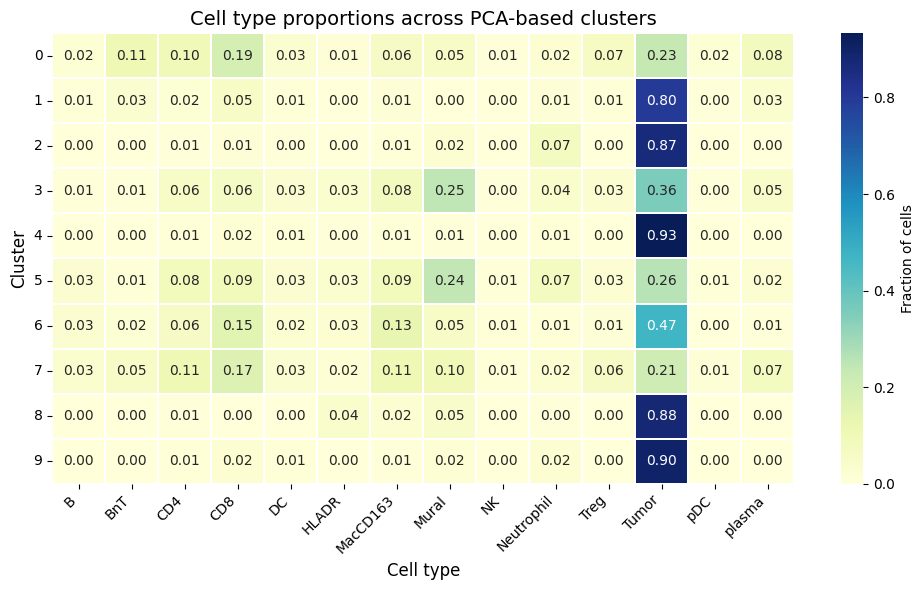

In [32]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    pca_celltype_fraction,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.3,
    cbar_kws={"label": "Fraction of cells"},
)

plt.title("Cell type proportions across PCA-based clusters", fontsize=14)
plt.xlabel("Cell type", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [38]:
scvi_celltype_abundance = (
    adata.obs
    .groupby(['scVI_clusters', 'celltypes'])
    .size()
    .unstack(fill_value=0)
)
scvi_celltype_fraction = scvi_celltype_abundance.apply(lambda x: x / x.sum(), axis=1)

/tmp/ipykernel_7690/1038000038.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['scVI_clusters', 'celltypes'])


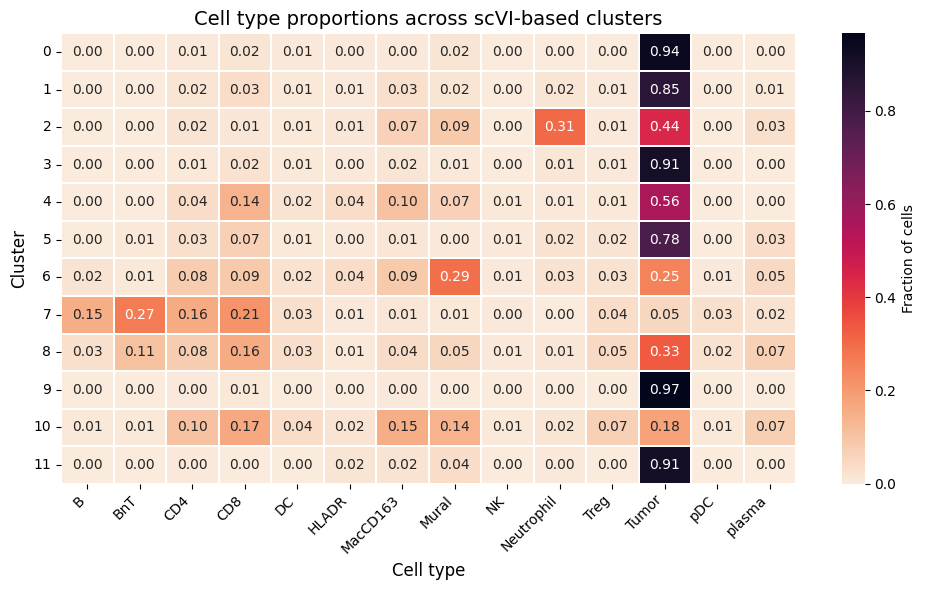

In [75]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    scvi_celltype_fraction,
    annot=True,
    fmt=".2f",
    cmap="rocket_r",
    linewidths=0.3,
    cbar_kws={"label": "Fraction of cells"},
)

plt.title("Cell type proportions across scVI-based clusters", fontsize=14)
plt.xlabel("Cell type", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.2) Mean marker expression across all clusters

In [44]:
# Convert the matrix to a DataFrame with appropriate labels
# mean marker expression
expr_df = pd.DataFrame(
    adata.layers['exprs'],
    columns=adata.var['marker'],
    index=adata.obs_names
)

expr_df['PCA_clusters'] = adata.obs['PCA_clusters'].values
expr_df['scVI_clusters'] = adata.obs['scVI_clusters'].values

marker_cols = adata.var['marker'].values

# Group by cluster and compute mean per marker
pca_mean_expr_df = expr_df.groupby('PCA_clusters')[marker_cols].mean()
scvi_mean_expr_df = expr_df.groupby('scVI_clusters')[marker_cols].mean()

/tmp/ipykernel_7690/1533198715.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pca_mean_expr_df = expr_df.groupby('PCA_clusters')[marker_cols].mean()
/tmp/ipykernel_7690/1533198715.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scvi_mean_expr_df = expr_df.groupby('scVI_clusters')[marker_cols].mean()


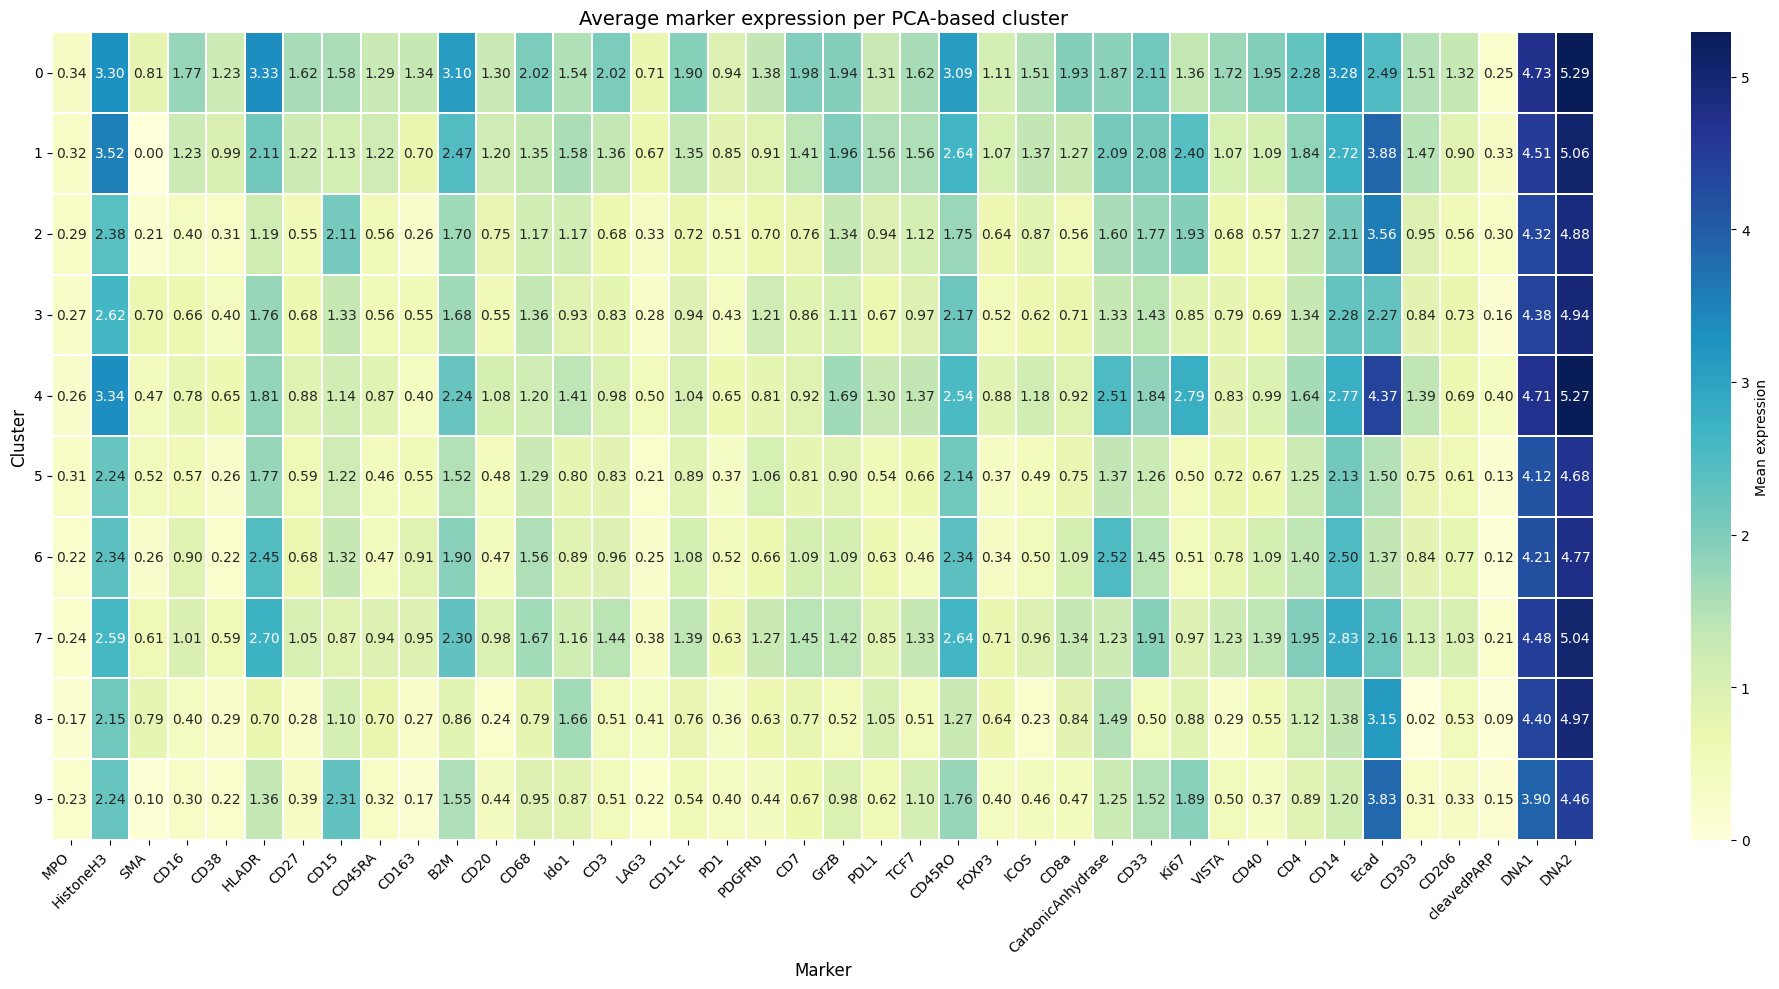

In [80]:
# plot PCA-based results

plt.figure(figsize=(20, 10))
sns.heatmap(
    pca_mean_expr_df,
    cmap="YlGnBu",
    annot=True,
    fmt='.2f',
    cbar_kws={"label": "Mean expression"},
    linewidths=0.3
)

plt.title("Average marker expression per PCA-based cluster", fontsize=14)
plt.xlabel("Marker", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

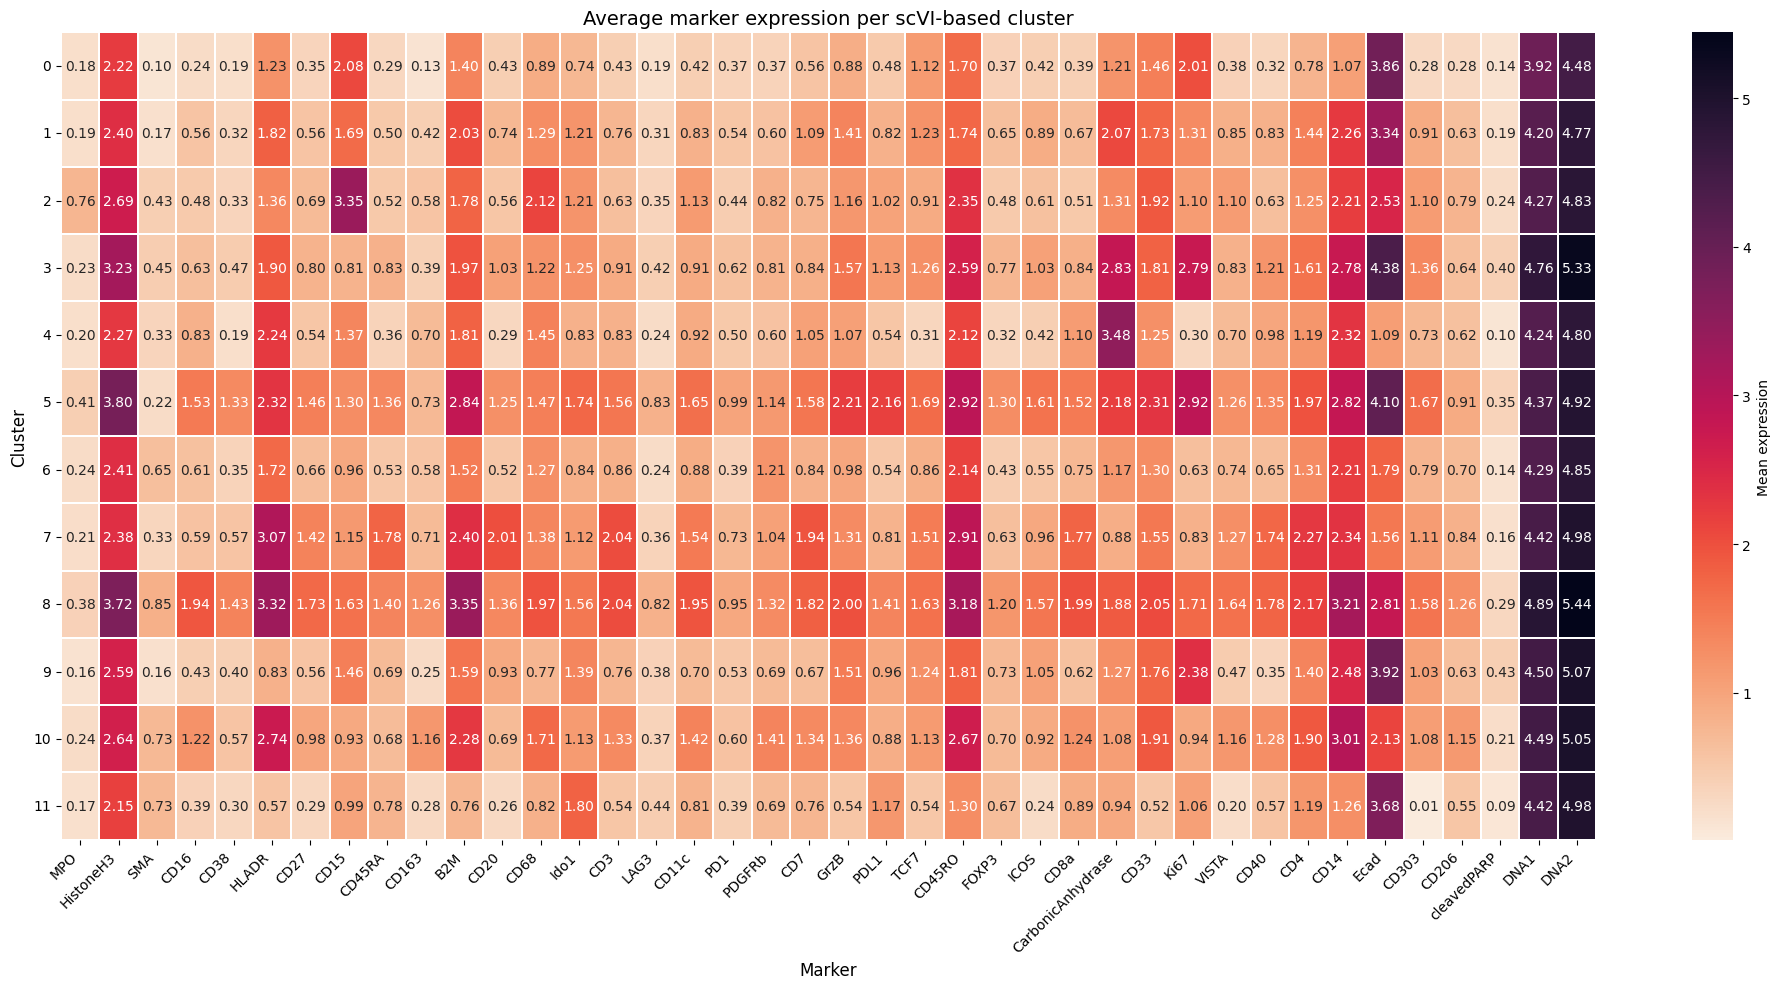

In [84]:
# plot scVI-based results

plt.figure(figsize=(20, 10))
sns.heatmap(
    scvi_mean_expr_df,
    cmap="rocket_r",
    annot=True,
    fmt='.2f',
    cbar_kws={"label": "Mean expression"},
    linewidths=0.3
)

plt.title("Average marker expression per scVI-based cluster", fontsize=14)
plt.xlabel("Marker", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 4.3) Cross-count matrix

In [ ]:
def plot_pretty_heatmap(data, title, xlabel, ylabel, fmt='d', cmap='rocket_r', figsize=(18, 8), cbar_label=None):
    plt.figure(figsize=figsize)
    sns.heatmap(
        data,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        linewidths=0.3,
        cbar_kws={"label": cbar_label} if cbar_label else None
    )
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


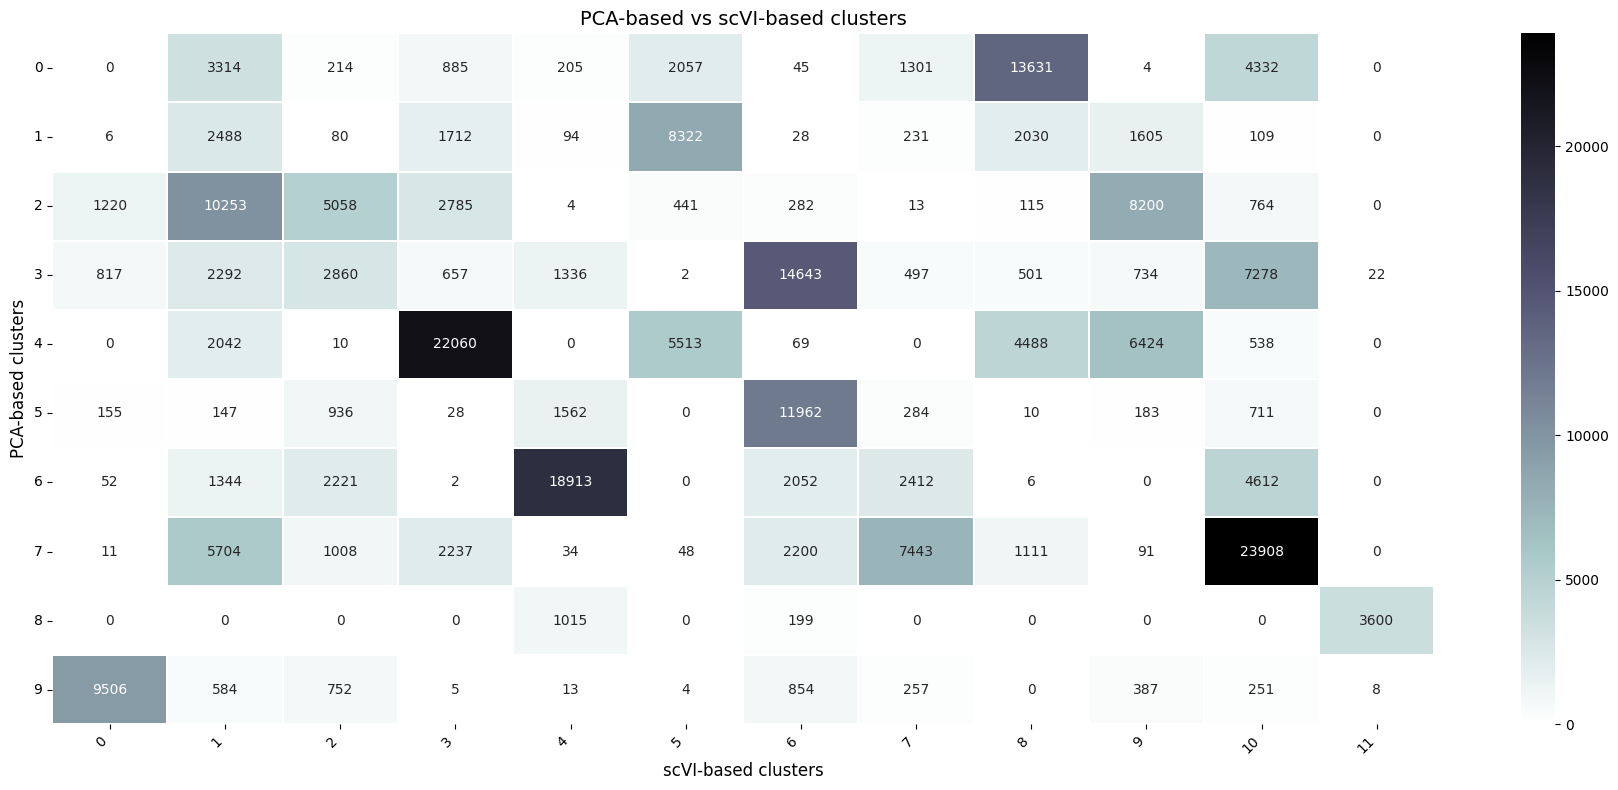

In [111]:
cross_count = pd.crosstab(adata.obs['PCA_clusters'], adata.obs['scVI_clusters'])

plt.figure(figsize=(18, 8))
sns.heatmap(
    cross_count,
    annot=True,
    fmt='d',
    cmap="bone_r",
    linewidths=0.3,
)
plt.title('PCA-based vs scVI-based clusters', fontsize=14)
plt.ylabel('PCA-based clusters', fontsize=12)
plt.xlabel('scVI-based clusters', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# PART 2: BERT-Charter

In [115]:
display(adata.obsp['spatial_connectivities'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1496914 stored elements and shape (253433, 253433)>

In [128]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.sparse.csgraph import shortest_path

class CellDataset(Dataset):
    """
    Dataset for BERT-Charter. For each cell, returns its multi-hop neighborhood:
    - 'input': marker vectors of each neighbor (unmasked)
    - 'target': same as input (used for masked reconstruction)
    - 'layers': hop distance (0=self, 1=1-hop, etc.)
    """

    def __init__(self, adata, n_layers=3, layer="exprs_normalized"):
        self.adata = adata
        self.n_layers = n_layers
        self.layer = layer

        self.X = adata.layers[self.layer]
        self.graph = adata.obsp['spatial_connectivities']
        self.neighs = self._build_neighbor_index()

    def _build_neighbor_index(self):
        n = self.adata.n_obs
        dist = shortest_path(self.graph, directed=False, unweighted=True, return_predecessors=False)
        neighs = []
        for i in range(n):
            cell_layers = []
            for d in range(self.n_layers):
                idx = np.where(dist[i] == d)[0]
                cell_layers.extend((j, d) for j in idx)
            neighs.append(cell_layers)
        return neighs

    def __len__(self):
        return self.adata.n_obs

    def __getitem__(self, cell_idx):
        neighbors = self.neighs[cell_idx]
        markers = []
        layers = []

        for nid, d in neighbors:
            markers.append(self.X[nid])
            layers.append(d)

        markers = np.stack(markers)
        layers = np.array(layers)

        return {
            "input": torch.tensor(markers, dtype=torch.float32),
            "target": torch.tensor(markers, dtype=torch.float32),
            "layers": torch.tensor(layers, dtype=torch.long)
        }


In [119]:
import torch
import torch.nn as nn

class NeighborhoodEmbedder(nn.Module):
    def __init__(self, input_dim, embedding_dim, n_layers):
        super().__init__()
        self.expr_embed = nn.Linear(input_dim, embedding_dim)
        self.layer_embed = nn.Embedding(n_layers, embedding_dim)
        self.mask_vector = nn.Parameter(torch.randn(embedding_dim))

    def forward(self, x, layers):
        """
        x: Tensor of shape [B, T, input_dim] - marker expressions
        layers: Tensor of shape [B, T] - hop distances (0 = self)
        Returns:
            Tensor of shape [B, T, embedding_dim]
        """
        expr_emb = self.expr_embed(x)                          # [B, T, embed_dim]
        layer_emb = self.layer_embed(layers)                   # [B, T, embed_dim]
        mask = (layers == 0).unsqueeze(-1)                     # [B, T, 1]
        masked_expr = torch.where(mask, self.mask_vector, expr_emb)  # broadcast
        return masked_expr + layer_emb


In [123]:
class BertCharter(nn.Module):
    def __init__(self, input_dim=40, embedding_dim=128, n_layers=3, n_heads=4):
        super().__init__()
        self.embedder = NeighborhoodEmbedder(input_dim, embedding_dim, n_layers)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=n_heads,
            batch_first=True  # [B, T, D]
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.output_proj = nn.Linear(embedding_dim, input_dim)

    def forward(self, x, layers):
        """
        x: [B, T, input_dim] - marker expressions
        layers: [B, T] - hop distances (0 = self)
        Returns:
            - encoder_out: [B, T, embedding_dim]
            - predicted_markers: [B, T, input_dim]
        """
        x_embed = self.embedder(x, layers)             # [B, T, embedding_dim]
        encoder_out = self.encoder(x_embed)            # [B, T, embedding_dim]
        predicted = self.output_proj(encoder_out)      # [B, T, input_dim]
        return encoder_out, predicted

In [148]:
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence

# This function is ruquired because the spatial graph is not connected

def custom_collate(batch):
    input_seqs = [item["input"] for item in batch]
    target_seqs = [item["target"] for item in batch]
    layer_seqs  = [item["layers"] for item in batch]  # this line was missing!

    input_padded  = pad_sequence(input_seqs, batch_first=True)
    target_padded = pad_sequence(target_seqs, batch_first=True)
    layer_padded  = pad_sequence(layer_seqs, batch_first=True)

    return {
        "input": input_padded,
        "target": target_padded,
        "layers": layer_padded
    }

def train_bert_charter(
    model,
    dataset,
    n_epochs=10,
    batch_size=64,
    mask_ratio=0.15,
    lr=1e-4,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    #dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=custom_collate)
    
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            x = batch["input"].to(device)     # [B, T, n_markers]
            y = batch["target"].to(device)    # [B, T, n_markers]
            layers = batch["layers"].to(device)  # [B, T]

            # Dynamic masking
            B, T, D = x.shape
            mask = (torch.rand(B, T, device=device) < mask_ratio)  # bool mask

            # Replace marker input with 0 for masked cells
            x_masked = x.clone()
            x_masked[mask] = 0.0

            # Replace layer id with 0 for masked cells
            layers_masked = layers.clone()
            layers_masked[mask] = 0

            # Forward
            _, preds = model(x_masked, layers_masked)  # [B, T, D]

            # Loss weighting
            weights = torch.ones_like(mask, dtype=torch.float32, device=device)
            weights[~mask] = 0.1  # 1.0 for masked, 0.1 for unmasked

            # Broadcast weights to marker dimension
            weights = weights.unsqueeze(-1)  # [B, T, 1]

            loss = F.mse_loss(preds, y, reduction='none')  # [B, T, D]
            loss = (loss * weights).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{n_epochs} — Loss: {avg:.4f}")


#### Because of memory limitations (I don't have 479 GiB to keep a 253433 x 253433 matrix containing shortest paths) I decided to downsaple the provided adata in a way that preserves the spatial structure of the data: I take the spatial graph I computed earlier and run BFS on it until I encounter the desired number of cells.


In [137]:
import numpy as np
import scipy.sparse as sp

# Parameters
target_size = 20000
G = adata.obsp["spatial_connectivities"].tocsr()
n_cells = adata.n_obs

# Tracking
visited = np.zeros(n_cells, dtype=bool)
result = []

while len(result) < target_size:
    # Start from a random unvisited node
    unvisited = np.where(~visited)[0]
    if len(unvisited) == 0:
        break  # all cells visited
    start = np.random.choice(unvisited)
    
    visited[start] = True
    queue = [start]
    result.append(start)

    # Standard BFS
    while queue and len(result) < target_size:
        current = queue.pop(0)
        row_start = G.indptr[current]
        row_end = G.indptr[current + 1]
        neighbors = G.indices[row_start:row_end]

        for neighbor in neighbors:
            if not visited[neighbor]:
                visited[neighbor] = True
                result.append(neighbor)
                queue.append(neighbor)
                if len(result) >= target_size:
                    break

# Subset adata
adata_sub = adata[result].copy()
print(f"Subgraph contains {adata_sub.n_obs} cells.")

Subgraph contains 20000 cells.


In [149]:
model = BertCharter(input_dim=40, embedding_dim=128, n_layers=3)
train_bert_charter(model, CellDataset(adata_sub), n_epochs=20, batch_size=64)

Epoch 1/20 — Loss: 9.0185
Epoch 2/20 — Loss: 5.0737
Epoch 3/20 — Loss: 4.3579
Epoch 4/20 — Loss: 4.0500
Epoch 5/20 — Loss: 4.0001
Epoch 6/20 — Loss: 3.9480
Epoch 7/20 — Loss: 3.9260
Epoch 8/20 — Loss: 3.9449
Epoch 9/20 — Loss: 3.9370
Epoch 10/20 — Loss: 3.9221
Epoch 11/20 — Loss: 3.9216
Epoch 12/20 — Loss: 3.9265
Epoch 13/20 — Loss: 3.9217
Epoch 14/20 — Loss: 3.9069
Epoch 15/20 — Loss: 3.8962
Epoch 16/20 — Loss: 3.9314
Epoch 17/20 — Loss: 3.9117
Epoch 18/20 — Loss: 3.9055
Epoch 19/20 — Loss: 3.9301
Epoch 20/20 — Loss: 3.9168
